In [109]:
import numpy as np

import cvxpy as cp
import matplotlib.pyplot as plt
import opt
import robustARMA_opt

In [110]:
def error_metrics(Y_hat, Y_test, H=None, H_gt=None, print_results=True):
    # Normalized error
    if Y_test.ndim == 2:
        norm_y = (Y_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum(1) / norm_y)
    else:
        norm_y = (Y_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum((1,2)) / norm_y)
    
    if print_results:
        print(f"Error in signal y: {err_y}")

    if H is not None and H_gt is not None:
        # Error wrt ground truth filter
        if H.ndim == 3: # Several filters
            norm_H = (H_gt**2).sum((1,2))
            err_H = np.mean(((H - H_gt)**2).sum((1,2)) / norm_H)
        else:
            norm_H = (H_gt**2).sum()
            err_H = ((H - H_gt)**2).sum() / norm_H

        if print_results:
            print(f"Error in filter: {err_H}")
        return err_y, err_H

    return err_y

In [111]:
def plot_filters(Hs):
    n_filt = Hs.shape[0]
    f, ax = plt.subplots(1, n_filt, figsize=(15,8))

    for i in range(n_filt):    
        im = ax[i].imshow(Hs[i,:,:])
        f.colorbar(im, ax=ax[i])

# Reading the data

In [112]:
#data = np.load('data_temp/temperatures2003_mod_knn8_N40.npz')
data = np.load('data_temp/temperatures2018_knn8_N28.npz') # 54 or 28 for only valid values, 36 for invalid values as well

In [113]:
A = data['A_bin']
temp_info = data['temps'] # data['X']

norm_data = False
if norm_data:
    temp_info -= np.mean(temp_info, 1)[:,None]
    temp_info /= np.std(temp_info, 1)[:,None]

Y = temp_info[:,1:]
X = temp_info[:,:-1]
N, N_dates = X.shape

In [137]:
temp_info.shape

(28, 365)

In [114]:
train_test_split = 0.7

random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

X_train = X[:,idxs_train]
Y_train = Y[:,idxs_train]
X_test = X[:,idxs_test]
Y_test = Y[:,idxs_test]
X_train.shape, Y_train.shape, N_dates

((28, 254), (28, 254), 364)

In [115]:
X_norm = (X_train.T - np.mean(X_train.T, axis=0))/np.std(X_train.T, axis=0)

C = np.cov(X_norm.T)

In [116]:
# Ground truth obtained using Least squares over all samples
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_test - H @ X_test)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_gt = H.value

In [117]:
y_ls_perf = H_gt @ X_test
err_ls_per, err_H_ls_per = error_metrics(y_ls_perf, Y_test, H_gt, H_gt)

Error in signal y: 0.004637336355386397
Error in filter: 0.0


# Multiple filters ARMA model

In [118]:
P = 2
Xs = np.array([temp_info[:,p:-P+p] for p in range(P)])
Y_mult = temp_info[:,P:]
N_dates_mult = Y_mult.shape[1]
Xs.shape, Y_mult.shape

((2, 28, 363), (28, 363))

In [119]:
idxs_mult = idxs.copy() # Using same split as in the previous cases, but needs to be adapted
for p in range(N_dates-P, N_dates): # Deleting invalid occurrences for this case
    idxs_mult = idxs_mult[idxs_mult != p]
idxs_train = idxs_mult[:int(train_test_split*N_dates_mult)]
idxs_test = idxs_mult[int(train_test_split*N_dates_mult):]
Xs_train = Xs[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Y_mult_train = Y_mult[:,idxs_train]
Y_mult_test = Y_mult[:,idxs_test]

In [120]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_test - cp.sum([Hs[p] @ Xs_test[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_gt = np.array([Hs[p].value for p in range(P)])

In [121]:
Y_hat_perf = np.sum(Hs_gt @ Xs_test, 0)
err_mult_per = error_metrics(Y_hat_perf, Y_mult_test)
#models.append("VARMA-LS-Perfect"); errs_y.append(err_mult_per)

Error in signal y: 0.0028367915811314042


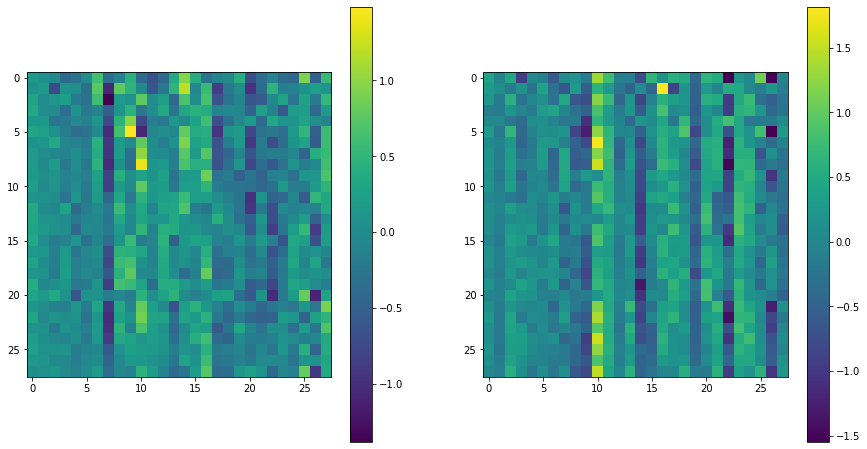

In [122]:
plot_filters(Hs_gt)

## Least squares

In [123]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_ls = np.array([Hs[p].value for p in range(P)])

In [124]:
Y_hat_mult_ls = np.sum(Hs_ls @ Xs_test, 0)
err_mult_ls, err_H_mult_ls = error_metrics(Y_hat_mult_ls, Y_mult_test, Hs_ls, Hs_gt)
#models.append("VARMA-LS"); errs_y.append(err_mult_ls); errs_H.append(err_H_mult_ls)

Error in signal y: 0.011029235143889746
Error in filter: 1.6512534056505075


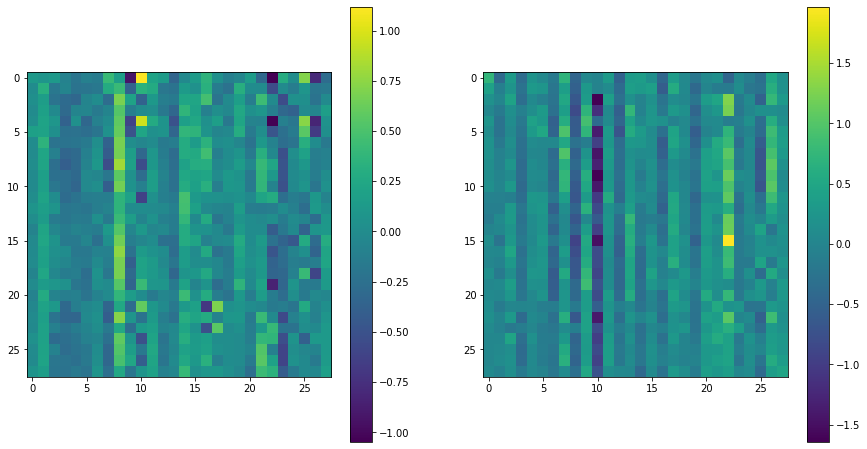

In [125]:
plot_filters(Hs_ls)

In [126]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
hs = [cp.Variable(K) for _ in range(P)]
Hs = [cp.sum([hs[p][k] * Spow[k,:,:] for k in range(K)]) for p in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
hs_ls = np.array([hs[p].value for p in range(P)])
H_mult_ls_gf = np.array([np.sum([hs_ls[p,k] * Spow[k,:,:] for k in range(5)], 0) for p in range(P)])

In [127]:
Y_hat_mult_ls_gf = np.sum(H_mult_ls_gf @ Xs_test, 0)
err_y_mult_ls_gf, err_H_mult_ls_gf = error_metrics(Y_hat_mult_ls_gf, Y_mult_test, H_mult_ls_gf, Hs_gt)
#models.append("VARMA-LS-GF"); errs_y.append(err_y_mult_ls_gf); errs_H.append(err_H_mult_ls_gf)

Error in signal y: 0.008211261622475857
Error in filter: 1.025786370275958


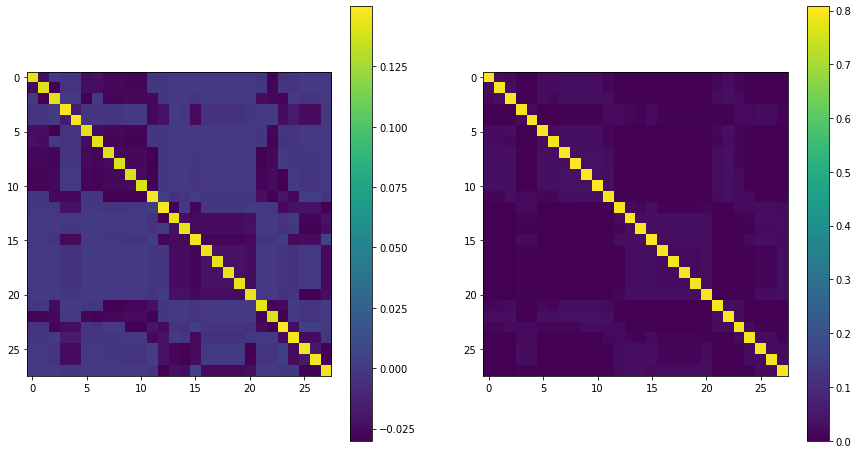

In [128]:
plot_filters(H_mult_ls_gf)

## Iterative (robust) algorithms

In [129]:
from robustARMA_opt import estHs_iter, estHs_iter_rew

In [130]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [131]:
iter, Hs_iter, Ss_iter = estHs_iter(Xs_train, Y_mult_train, A, C, args)

In [132]:
Y_hat_mult_iter = np.sum(Hs_iter @ Xs_test, 0)
err_mult_iter, err_Hs_mult_iter = error_metrics(Y_hat_mult_iter, Y_mult_test, Hs_iter, Hs_gt)
#models.append("VARMA-RGFI"); errs_y.append(err_mult_iter); errs_H.append(err_Hs_mult_iter)

Error in signal y: 0.008301181981368592
Error in filter: 1.0038424440458906


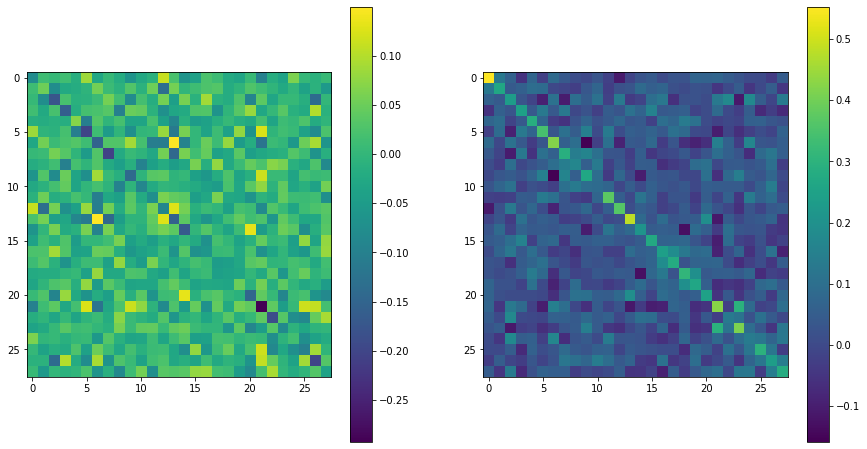

In [133]:
plot_filters(Hs_iter)

In [134]:
iter, Hs_iter_rew, Ss_iter_rew = estHs_iter_rew(Xs_train, Y_mult_train, A, C, args_rew)

In [135]:
Y_hat_mult_iter_rew = np.sum(Hs_iter_rew @ Xs_test, 0)
err_mult_iter_rew, err_Hs_mult_iter_rew = error_metrics(Y_hat_mult_iter_rew, Y_mult_test, Hs_iter_rew, Hs_gt)
#models.append("VARMA-RGFI-REW"); errs_y.append(err_mult_iter_rew); errs_H.append(err_Hs_mult_iter_rew)

Error in signal y: 0.008300166357692382
Error in filter: 1.0038442627748339


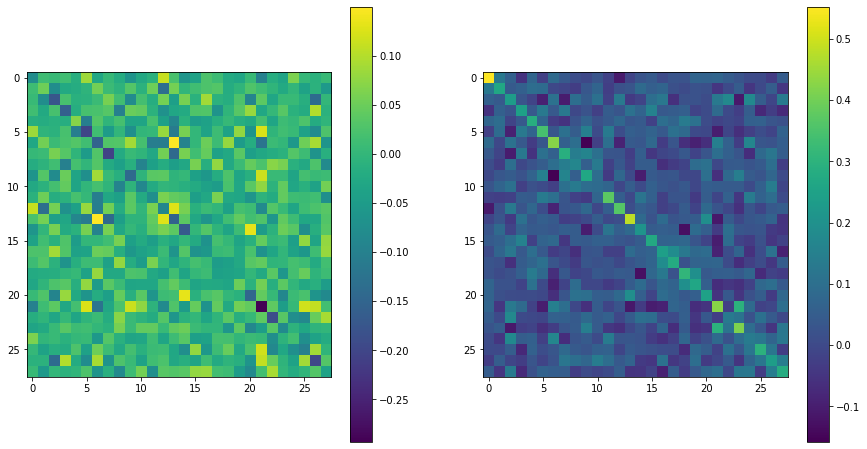

In [136]:
plot_filters(Hs_iter_rew)